In [1]:
import torch, matplotlib.pyplot as plt, numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision.utils as vutils
from torchsummary import summary

# Training/tesing data
1. import database of images
2. show different labels (5000 images for each label)
3. pick a label 
4. take images of that label and transform it

Files already downloaded and verified
(32, 32)


157

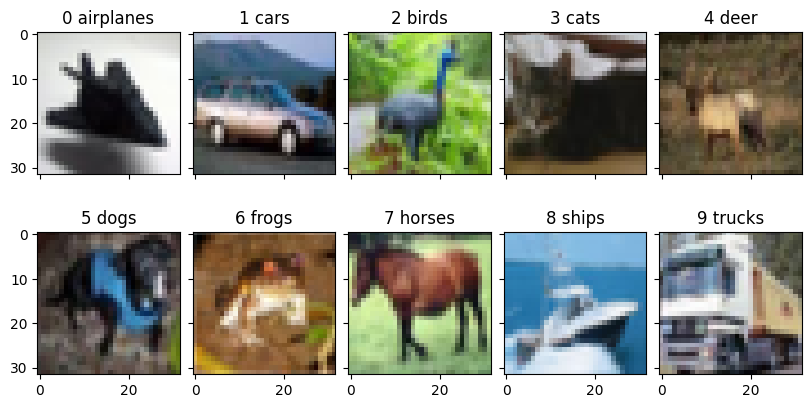

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root=r'../../data/CIFAR-10',\
              train=True, download=True, transform=None)


labels = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
labels_ids = {i:tag for i,tag in enumerate(labels)}

fig, ax = plt.subplots(2,5, figsize = (8,4), layout='constrained', sharex=True, sharey=True)
ax = ax.flatten()
solved_IDs = []
itr = iter(train_dataset)
while len(solved_IDs) < 10:
    img, ID = next(itr)
    if ID not in solved_IDs:
        ax[ID].imshow(img)
        ax[ID].set_title(f'{str(ID)} {labels[ID]}')
        solved_IDs.append(ID)

print(img.size)
# id_cnt = np.zeros(len(labels))
# for _,i in train_dataset:
#     id_cnt[i] += 1
# print(id_cnt)
img = np.array(img, np.uint8)
train_sub_dataset = np.array([img for img,tag in train_dataset if tag == 1])#.resize((64,64))
train_sub_dataset_tr = np.array([transform(img) for img in train_sub_dataset])
train_sub_dataset_tr = torch.tensor(train_sub_dataset_tr,dtype=torch.float32, device = device)
batch_size = 32
dataloader = torch.utils.data.DataLoader(train_sub_dataset_tr, batch_size=batch_size, shuffle=True)
len(dataloader)

In [3]:
train_sub_dataset_tr[0].shape

torch.Size([3, 32, 32])

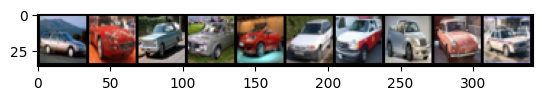

In [4]:
from torchvision.utils import make_grid
aa = torch.tensor(train_sub_dataset[:10,...]).permute(0,3,2,1)
grid = make_grid(aa, nrow = 1).permute(2,1,0)
plt.imshow(grid)

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
import torch.nn as nn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32



# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [7]:
# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. ``(ngf*8) x 4 x 4``
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. ``(ngf*4) x 8 x 8``
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. ``(ngf*2) x 16 x 16``
#             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. ``(ngf) x 32 x 32``
#             nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. ``(nc) x 64 x 64``
#         )

#     def forward(self, input):
#         return self.main(input)

In [8]:
L1_in = nz
L1_out = ngf * 4
L2_out = ngf * 2
L3_out = ngf

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( L1_in, L1_out, 4, 1, 0, bias=False),
            nn.BatchNorm2d(     L1_out  ),
            nn.ReLU(            True    ),
            nn.ConvTranspose2d( L1_out, L2_out, 4, 2, 1, bias=False),
            nn.BatchNorm2d(     L2_out  ),
            nn.ReLU(            True    ),
            nn.ConvTranspose2d( L2_out, L3_out, 4, 2, 1, bias=False),
            nn.BatchNorm2d(     L3_out  ),
            nn.ReLU(            True    ),
            nn.ConvTranspose2d( L3_out, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init);
summary(netG, (nz, 1, 1));
noise = torch.randn(32, nz, 1, 1, device=device)
# Generate fake image batch with G
netG(noise).shape


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-1              [-1, 128, 4, 4]           204,800
|    └─BatchNorm2d: 2-2                  [-1, 128, 4, 4]           256
|    └─ReLU: 2-3                         [-1, 128, 4, 4]           --
|    └─ConvTranspose2d: 2-4              [-1, 64, 8, 8]            131,072
|    └─BatchNorm2d: 2-5                  [-1, 64, 8, 8]            128
|    └─ReLU: 2-6                         [-1, 64, 8, 8]            --
|    └─ConvTranspose2d: 2-7              [-1, 32, 16, 16]          32,768
|    └─BatchNorm2d: 2-8                  [-1, 32, 16, 16]          64
|    └─ReLU: 2-9                         [-1, 32, 16, 16]          --
|    └─ConvTranspose2d: 2-10             [-1, 3, 32, 32]           1,536
|    └─Tanh: 2-11                        [-1, 3, 32, 32]           --
Total params: 370,624
Trainable params: 370,624
Non-trainable para

torch.Size([32, 3, 32, 32])

In [9]:
# ndf = 64
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is ``(nc) x 64 x 64``
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf) x 32 x 32``
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*2) x 16 x 16``
#             nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*4) x 8 x 8``
#             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. ``(ndf*8) x 4 x 4``
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)
    
# netD = Discriminator(ngpu).to(device)
# summary(netD, (3, 64, 64));

In [40]:
ndf = 32
    
L1_in = nz
L1_out = ndf * 4
L2_out = ndf * 2
L3_out = ndf

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(


            nn.Conv2d(nc, L3_out, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(L3_out, L2_out, 4, 2, 1, bias=False),
            nn.BatchNorm2d(L2_out),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(L2_out, L1_out, 4, 2, 1, bias=False),
            nn.BatchNorm2d(L1_out),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(L1_out, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator(ngpu).to(device)

netD.apply(weights_init)

#summary(netD, (3, 32, 32));

netD(train_sub_dataset_tr[:1]) # BatchNorm2d() requires a batch xD

tensor([[[[0.5852]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [41]:
import torch.optim as optim
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Learning rate for optimizers
lr = 0.0002
lr2 = 0.00005
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr2, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [42]:

netD.apply(weights_init)
netG.apply(weights_init);
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

num_epochs = 600
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d\t/%d][\t%d/%d\t] Loss_D: %.4fLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='\r')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


In [32]:
# import matplotlib.animation as animation
# from IPython.display import HTML
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True);

# HTML(ani.to_jshtml())

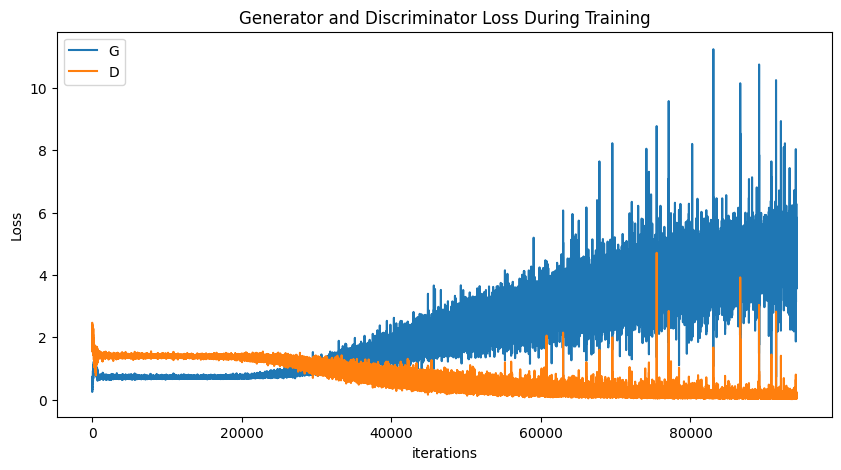

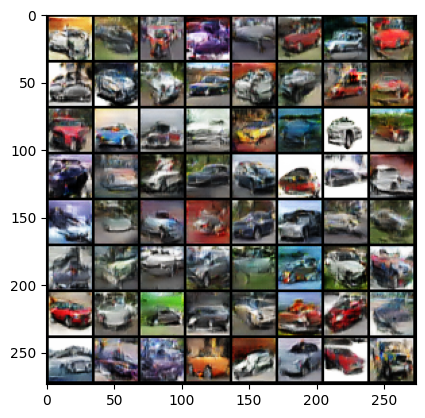

In [43]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show();

plt.imshow(np.transpose(img_list[-1],(1,2,0)));